In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import cm as CM
from matplotlib.colors import LogNorm,PowerNorm,LinearSegmentedColormap,ListedColormap

In [2]:
%matplotlib inline

In [3]:
def get_axis_limits(ax, scalex=.03,scaley=0.93):
    return ax.get_xlim()[1]*scalex, ax.get_ylim()[1]*scaley

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
def plotMap(filename,i):
    cities=pd.read_table(filename,sep=',',na_values=[-9999])
    #cities=cities[cities['Count']>=10]
    #cities=cities[0<=cities['WDIR850']]
    #cities=cities[cities['WDIR850']<=90]
    # Extract the data we're interested in
    lat = cities['lat_bin'].values
    lon = cities['lon_bin'].values
    ccn0 = cities['H14_1.0'].values
    tcb = cities['Hcbs1.0'].values
    ccn = ccn0-tcb
    #u850,v850=mpcalc.get_wind_components(cities['WSPD850'],cities['WDIR850'])
    lat_max=np.nanmax(lat)
    lon_max=np.nanmax(lon)
    lat_min=np.nanmin(lat)
    lon_min=np.nanmin(lon)
    ccn_max=np.nanmax(ccn)
    print(ccn_max)
    ccn_min=np.nanmin(ccn)
    print(ccn_min)
    tcb_max=np.nanmax(tcb)
    print(tcb_max)
    tcb_min=np.nanmin(tcb)
    print(tcb_min)
    #Set the projection information Cannot label gridlines on a LambertConformal plot. Only PlateCarree and Mercator plots are currently supported.
##add shapefile
    # add borders, coastline, rivers, lakes, and provinces of China
    #proj = ccrs.PlateCarree(central_longitude=118.8)
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    #fig, ax = plt.subplots(figsize=(11.8, 8),subplot_kw=dict(projection=proj))
    #ax.background_img(name='BM', resolution='high')
    #Zoom in
    #axes[i].set_extent([115, 119, 22, 25])
    axes[i].set_extent([115, 123, 27, 35])#yrd

    #Add map features
    axes[i].add_feature(cfeature.LAND, facecolor='0.99') #Grayscale colors can be set using 0 (black) to 1 (white)
    axes[i].add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    axes[i].add_feature(cfeature.BORDERS.with_scale('10m'), zorder=10, linestyle=':') # high resolution
    axes[i].add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=10, linestyle=':') # mediate resolution
    axes[i].add_feature(cfeature.RIVERS) # low resolution
    #ax.stock_img()
    axes[i].gridlines(ylocs=np.arange(0,90,1),xlocs=np.arange(0,180,1),draw_labels=False,linestyle='--',alpha=0.7)
    #axes[i].xaxis.set_major_formatter(lon_formatter)
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                       degree_symbol='',
                                       dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.1f',
                                      degree_symbol='')
    '''
    if i in range(4,6,1):
        print(axes[i])
        axes[i].set_xticks([110, 112, 114, 116, 118, 120], crs=ccrs.PlateCarree())
    
        axes[i].xaxis.set_major_formatter(lon_formatter)
    if i in range(0,6,2):
        print(axes[i])
        axes[i].set_yticks([22, 23, 24, 25], crs=ccrs.PlateCarree())
        axes[i].yaxis.set_major_formatter(lat_formatter)
    '''
    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
    axes[i].add_feature(states_provinces, edgecolor='gray', zorder=10)
    #fname = 'D:\data\map\CHN_adm2.shp'
    fname = 'D:\data\map\yrd_grug.shp'
    adm1_shapes = list(Reader(fname).geometries())
    axes[i].add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.9,linewidths=0.8)
    #newcmap = cmocean.tools.crop_by_percent(cmocean.cm.phase_r, 20, which='both', N=40)
    #bounds = [0, 50, 100, 200, 500,
    #      800, 1000, 1200, 1400,1600]
    #norm = mpl.colors.BoundaryNorm(bounds, newcmap.N)
    #norm = mpl.colors.LogNorm()
    #norm = mpl.colors.SymLogNorm(linthresh=0.03, linscale=0.1, vmin=50, vmax=ccn_max)
    terrain = CM.get_cmap('terrain', 40)
    newcolors = terrain(np.linspace(0, 0.75, 10))
    newcmap = ListedColormap(newcolors)
    ccn_sca=axes[i].scatter(lon,lat,#latlon=True,
          c=ccn/1000, s=(tcb/10),
          cmap=newcmap,norm=PowerNorm(gamma=0.7),alpha=0.5,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
          #cmap=CM.get_cmap('rainbow',40),norm=LogNorm(vmin=max(ccn.min(),0.1),clip=True),alpha=0.5,transform=ccrs.PlateCarree())
          #Normalize a given value to the 0-1 range on a log scale
          #cmap=CM.get_cmap('jet'),alpha=0.8,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
    #Add lat/lon gridlines every 20° to the map
    #plt.colorbar(label=r'CCN ($cm^{-3}$)')
    #plt.clim(0,1600)
    ccn_sca.set_clim(0,8)
    #ccn_sca.xformatter = LONGITUDE_FORMATTER
    #ccn_sca.yformatter = LATITUDE_FORMATTER
    #ccn_sca.xlabel_style = {'size': 15, 'color': 'gray'}
    #ccn_sca.xlabel_style = {'color': 'red', 'weight': 'bold'}
# make legend with dummy points
    '''
    for a in [0,10,20]:
        plt.scatter([], [], c='k', alpha=0.5, s=(15*a+20),
                label=str(a)+'')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left',title= 'AQI',
#           bbox_to_anchor=(,0),ncol=5)
    plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',title= 'Tb-temperature',
           bbox_to_anchor=(0,-0.10,1,0.2),
           mode="expand", borderaxespad=0, ncol=6)
    '''
    #plt.title("2013-2018 Summer", fontsize=20)
    #X, Y = np.meshgrid(lon, lat)
    #U, V = np.meshgrid(u850, v850)
    #ax.barbs(X, Y, U, V, length=5,
    #         sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
    #         linewidth=0.95, transform=ccrs.PlateCarree())
    
    return ccn_sca

In [5]:
filenames=["new_wind/allsum-0.25-New-all_0-360_850hpa.csv","new_wind/allsum-0.25-New-s2_0-360_850hpa.csv",
           "new_wind/allsum-0.25-New-b2_270-360_850hpa.csv","new_wind/allsum-0.25-New-b2_0-90_850hpa.csv",
           "new_wind/allsum-0.25-New-b2_180-270_850hpa.csv","new_wind/allsum-0.25-New-b2_90-180_850hpa.csv"]

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


13836.0
-467.5
3000.0
0.0
12287.5
-238.5
3000.0
46.0
12717.0
-640.0
3000.0
0.0
12036.666666666666
-445.0
2998.0
0.0
13028.0
-697.3333333333333
3000.0
36.0
13487.0
-116.0
2994.0
36.0


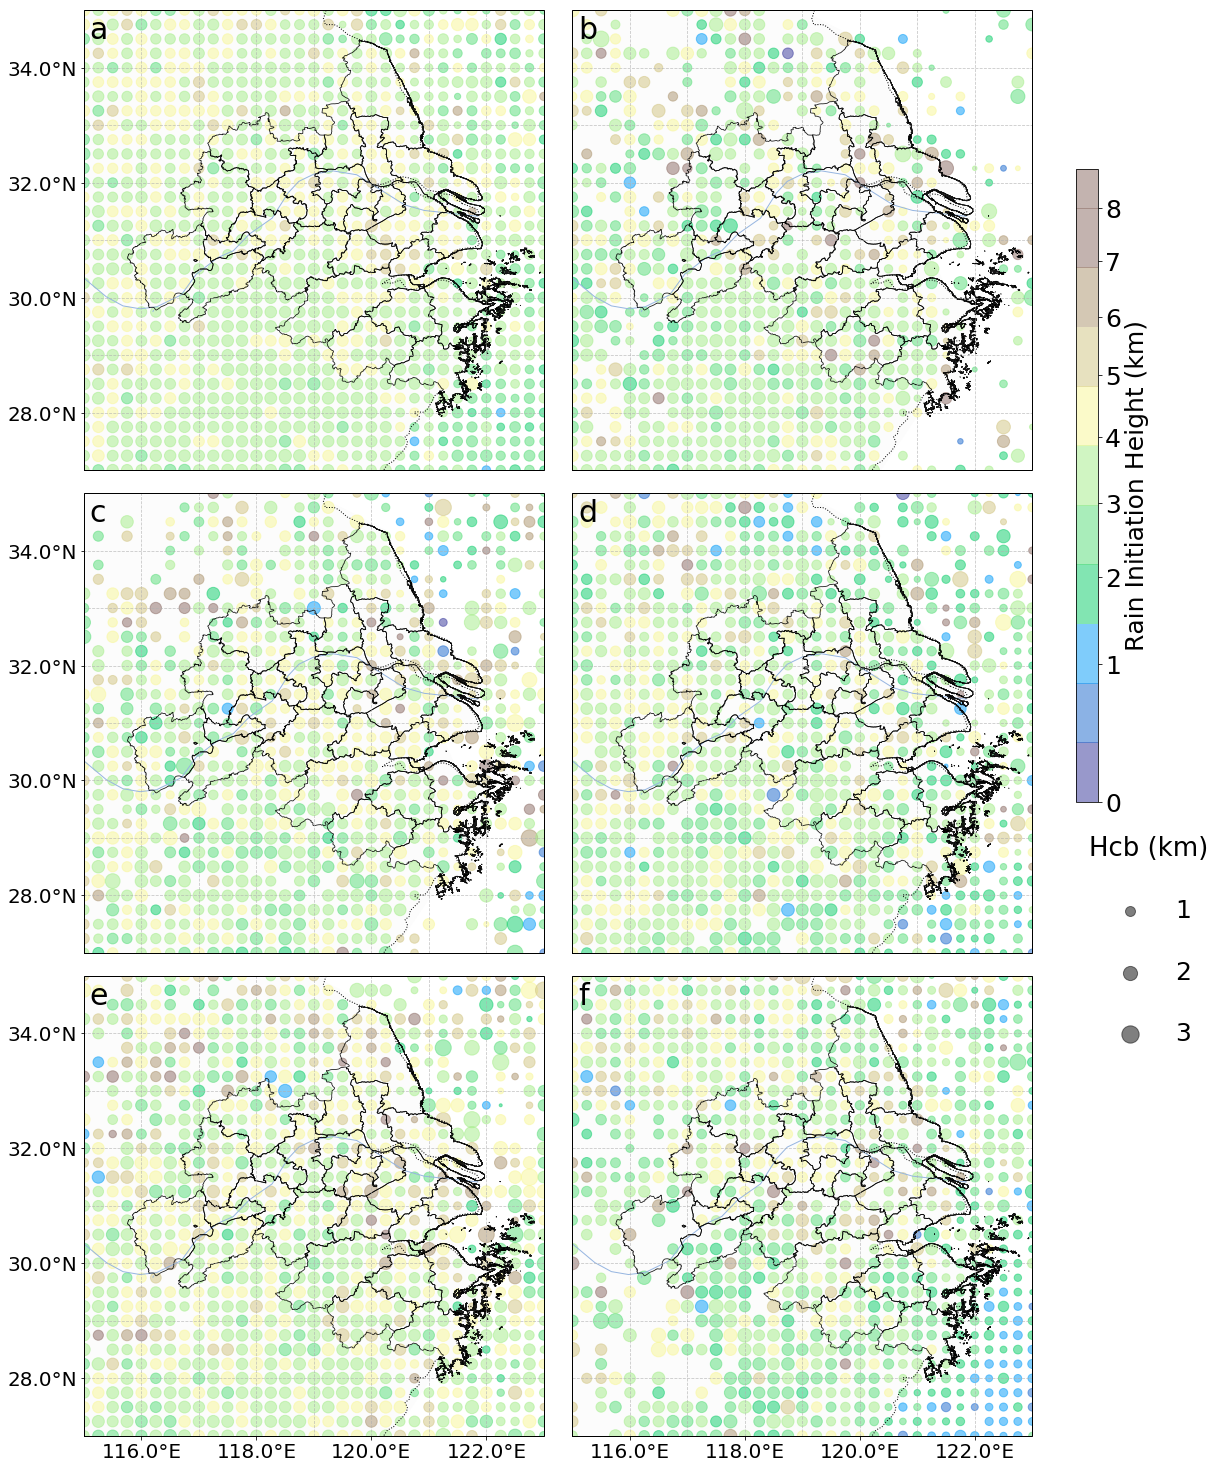

In [6]:
'''
fig, big_axes = plt.subplots(figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True)

for row, big_ax in enumerate(big_axes, start=1):
    #big_ax.set_title("Subplot row %s \n" % row, fontsize=16)

    # Turn off axis lines and ticks of the big subplot
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(0,0,0,0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
'''
axes=['ax1', 'ax2','ax3','ax4','ax5','ax6']
#NUM=['A)', 'B)','C)','D)','E)','F)']
NUM=['a', 'b','c','d','e','f']
fig = plt.figure(figsize=[15, 22])#比例也决定了间隔的大小
lon_formatter = LongitudeFormatter(number_format='.1f')
                                       #degree_symbol='',
                                       #dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f')
                                      #degree_symbol='')
    
axes[0] = fig.add_subplot(3,2,1,projection=ccrs.PlateCarree())
#axes[0].set_xticks([110, 112, 114, 116, 118, 120], crs=ccrs.PlateCarree())
#axes[0].xaxis.set_major_formatter(lon_formatter)
#axes[0].set_yticks([22, 23, 24, 25], crs=ccrs.PlateCarree())
#axes[0].yaxis.set_major_formatter(lat_formatter)
axes[1] = fig.add_subplot(3,2,2,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
axes[2] = fig.add_subplot(3,2,3,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
axes[3] = fig.add_subplot(3,2,4,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
axes[4] = fig.add_subplot(3,2,5,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])
axes[5] = fig.add_subplot(3,2,6,projection=ccrs.PlateCarree(),sharex=axes[0],sharey=axes[0])

for i in range(4,6,1):
    #if i in range(4,6,1):
    axes[i].set_xticks([114, 116, 118, 120,122,124],crs=ccrs.PlateCarree())
    axes[i].set_xticklabels([114, 116, 118, 120,122,124],fontsize=20)  
    axes[i].xaxis.set_major_formatter(lon_formatter)
for i in range(0,6,2):
    #if i in range(0,6,2):
    axes[i].set_yticks([26,28,30,32,34,36], crs=ccrs.PlateCarree())
    axes[i].set_yticklabels([26,28,30,32,34,36],fontsize=20)
    axes[i].yaxis.set_major_formatter(lat_formatter)
        
plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.01,hspace=0.05)

for i in range(0,6):
    #axes[i] = fig.add_subplot(3,2,i+1,projection=ccrs.PlateCarree(),sharex=ax1,sharey=ax1)
    #plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.05,hspace=0.05)
    ctt=plotMap(filenames[i],i)
    transform = ccrs.PlateCarree()._as_mpl_transform(axes[i])
    #axes[i].set_title('Plot title ' + str(i+1))
    axes[i].annotate(NUM[i],xy=(115.1,34.5),xycoords=transform,fontsize=30)
    #axes[i].annotate(NUM[i], xy=get_axis_limits(axes[i]),fontsize=15) 图片会变大
#fig.text(0.5, -0.04, 'Latitude, Longitude', ha='center',fontsize=20)
#fig.text(-0.02, 0.35, 'Height (m)', va='center', rotation='vertical',fontsize=20)
cax = fig.add_axes([0.98, 0.45, 0.02, 0.4])
cbar=plt.colorbar(ctt, cax, orientation='vertical',label=r'Rain Initiation Height (km)',extend="max",extendfrac=1/15,extendrect=True)
#plt.colorbar(label=r'CCN ($cm^{-3}$)')
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r'Rain Initiation Height (km)',fontsize=25)
for a in [1,2,3]:
    plt.scatter([], [], c='k', alpha=0.5, s=(a*1000/10),
                label=str(a)+'')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left',title= 'AQI',
#           bbox_to_anchor=(,0),ncol=5)
leg=plt.legend(scatterpoints=1, frameon=False,
       labelspacing=1.5, loc='lower left',fontsize=25,
       bbox_to_anchor=(0.1,-0.4,1,0.2),
       borderaxespad=0, ncol=1)
leg.set_title('Hcb (km)',prop = {'size': 26, 'family':'sans-serif'})
#plt.savefig("figureYRD1.pdf",bbox_inches='tight')
plt.savefig("figureYRD-rih_use.png",dpi=600,bbox_inches='tight')

fig.set_facecolor('w')
#plt.tight_layout()和subplots_adjust冲突

In [2]:
print('$^\circ$C')

$^\circ$C


In [2]:
print(u'\u2103')

℃


[Why the annotate worked unexpected here in cartopy?](https://stackoverflow.com/questions/25416600/why-the-annotate-worked-unexpected-here-in-cartopy)